# Dopamine Side Learning Y-maze

## Load packages

In [1]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(emmeans) # Post-hoc analysis on the model
require(DHARMa) # Evaluate model fit
require(AICcmodavg) # For model selection and averaging

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: emmeans

Loading required package: DHARMa

This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: AICcmodavg


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:lme4’:

    checkConv




## Clean-up

In [2]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

## Load data

In [3]:
ELP = read.csv("./Data/All/ELP_all.csv")
ELP = subset(ELP, ELP$Experiment == "7") # Subset for Dopamine experiment
head(ELP, n = 1) # Check it was loaded correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Experiment,Initial_Binary,Final_Binary,Switched_Binary,TSM_Bin
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
1669,11.07.22,13:35,Alexandra Koch,24.3,20th April - Portugal,4-days,56,57,1,2,⋯,NA,536,8.9,NA,No,7,1,1,0,0-30


## Ensure relevant variables are factors

In [4]:
ELP$Collection_Date = as.factor(ELP$Collection_Date)
ELP$Experimentor = as.factor(ELP$Experimentor)
ELP$Starvation_Period = as.factor(ELP$Starvation_Period)
ELP$Colony_ID = as.factor(paste0(ELP$Donor_Colony, "_", ELP$Recipient_Colony))
ELP$Ant_ID = as.factor(ELP$Ant_ID)

ELP$Visit = as.factor(ELP$Visit)
ELP$Solution = as.factor(ELP$Solution)
ELP$Solution = relevel(ELP$Solution, "Control")
ELP$Reward_Side = as.factor(ELP$Reward_Side)
ELP$TSM_Bin = as.factor(ELP$TSM_Bin)

ELP$Initial_Binary = as.factor(ELP$Initial_Binary)
ELP$Final_Binary = as.factor(ELP$Final_Binary)

## Identify relevant random effects

In [5]:
unique(ELP$Collection_Date)
unique(ELP$Experimentor)
unique(ELP$Starvation_Period)
unique(ELP$Colony_ID)
unique(ELP$Ant_ID)

[1] 11.07.22 12.07.22 25.07.22 26.07.22 27.07.22 08.08.22 09.08.22 10.08.22
 [9] 16.08.22 17.08.22
10 Levels: 08.08.22 09.08.22 10.08.22 11.07.22 12.07.22 16.08.22 ... 27.07.22

[1] Alexandra Koch
Levels: Alexandra Koch

[1] 4-days
Levels: 4-days

[1] 56_57 16_13 9_11 
Levels: 16_13 56_57 9_11

[1] 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
[76] 76 77 78 79 80
80 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 80

## Do initial and final choices significantly differ?

In [6]:
ELP_choice_diff = melt(ELP, measure.vars = c("Initial_Binary", "Final_Binary"))

ELP_choice_diff$variable = as.factor(ELP_choice_diff$variable)
ELP_choice_diff$value = as.factor(ELP_choice_diff$value)

ELP_choice_diff_mod = glmer(value ~ variable + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP_choice_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

e = emmeans(ELP_choice_diff_mod, ~variable, type = "response")
pairs(e)

boundary (singular) fit: see help('isSingular')



 contrast                      odds.ratio    SE  df null z.ratio p.value
 Initial_Binary / Final_Binary      0.794 0.158 Inf    1  -1.157  0.2471

Tests are performed on the log odds ratio scale 

p-value > 0.1 hence there is no statistical difference between initial and final decision therefore we will use final decision henceforth.

## Define models

### 1. Null model
**Biological hypothesis:** Ants randomly choose a Y-maze arm.

In [7]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 2. Visit model
**Biological hypothesis:** Ants learn to associate a Y-maze arm with a reward. Over consecutive visits more ants choose the correct arm.

In [8]:
visit_mod = glmer(Final_Binary ~ Visit + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 3. Solution model
**Biological hypothesis:** The presence of a psychoactive chemical in the reward alters the ants ability to choose a Y-maze arm.

In [9]:
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 4. Side model
**Biological hypothesis:** Ants have an intrinsic predisposition towards turning left or right. This is associated with brain lateralisation which has been shown in multiple organisms.

In [10]:
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 5. Time since marking model
**Biological hypothesis:** Ants that had a waiting period (>30 minutes) after learning the reward/side association have different recall strenght. This should be associated with long-term memory formation which should be stronger.

In [11]:
tsm_mod = glmer(Final_Binary ~ TSM_Bin + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 6. Solution and Visit with Time since marking model
**Biological hypothesis:** The effects of a psychoactive chemical might be time dependent.

In [12]:
solution_time_mod = glmer(Final_Binary ~ Solution + TSM_Bin + Visit + Solution:TSM_Bin + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 7. Maximal model
**Biological hypothesis:** All of the available variables contribute towards ant learning.

In [13]:
max_mod = glmer(Final_Binary ~ Solution + Visit + TSM_Bin + Reward_Side + Solution:TSM_Bin + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



## Check if the most complex model (max_mod) is a good fit to the data

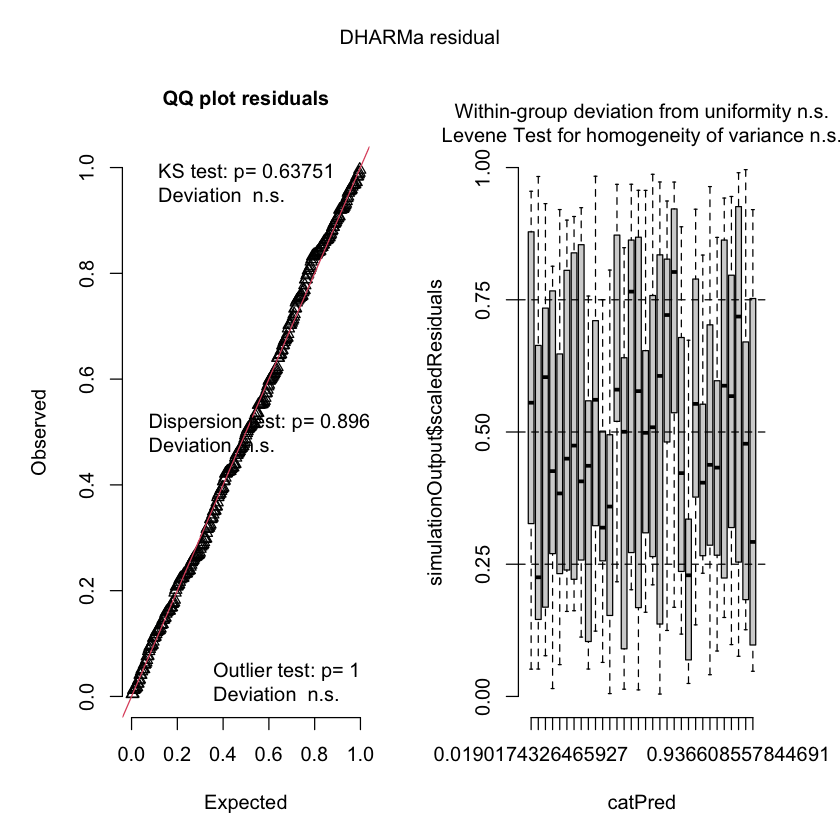

In [14]:
simres = simulateResiduals(max_mod)
plot(simres, asFactor = T)

The maximum model seems to hold all assumptions and be a god fit to the data. Therefore, all simpler models should be equally good.
## Model Selection

In [15]:
cand_models = list("null_mod" = null_mod, 
                   "visit_mod" = visit_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,7,347.9092,0.000000,1.00000000,0.53509357,-166.7751,0.5350936
1,null_mod,4,350.6139,2.704690,0.25863311,0.13839291,-171.2435,0.6734865
4,side_mod,5,351.3186,3.409336,0.18183271,0.09729752,-170.5638,0.7707840
5,tsm_mod,5,351.8240,3.914730,0.14123006,0.07557130,-170.8164,0.8463553
3,solution_mod,5,352.0304,4.121136,0.12738158,0.06816107,-170.9196,0.9145164
6,solution_time_mod,10,352.7018,4.792516,0.09105805,0.04872458,-165.9949,0.9632409
7,max_mod,11,353.2654,5.356114,0.06869649,0.03675905,-165.2041,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,7,347.9092,0.000000,1.00000000,0.53509357,-166.7751,0.5350936
1,null_mod,4,350.6139,2.704690,0.25863311,0.13839291,-171.2435,0.6734865
4,side_mod,5,351.3186,3.409336,0.18183271,0.09729752,-170.5638,0.7707840
5,tsm_mod,5,351.8240,3.914730,0.14123006,0.07557130,-170.8164,0.8463553
3,solution_mod,5,352.0304,4.121136,0.12738158,0.06816107,-170.9196,0.9145164
6,solution_time_mod,10,352.7018,4.792516,0.09105805,0.04872458,-165.9949,0.9632409


**The visit_mod explains 54% of the total variance explained by all of the models tested.**

In [16]:
evidence(aic.table = aictab(cand_models))

Evidence ratio between models 'visit_mod' and 'null_mod':
3.87

The visit model is 4 times more parsimonious than the next "best" model (null_mod).

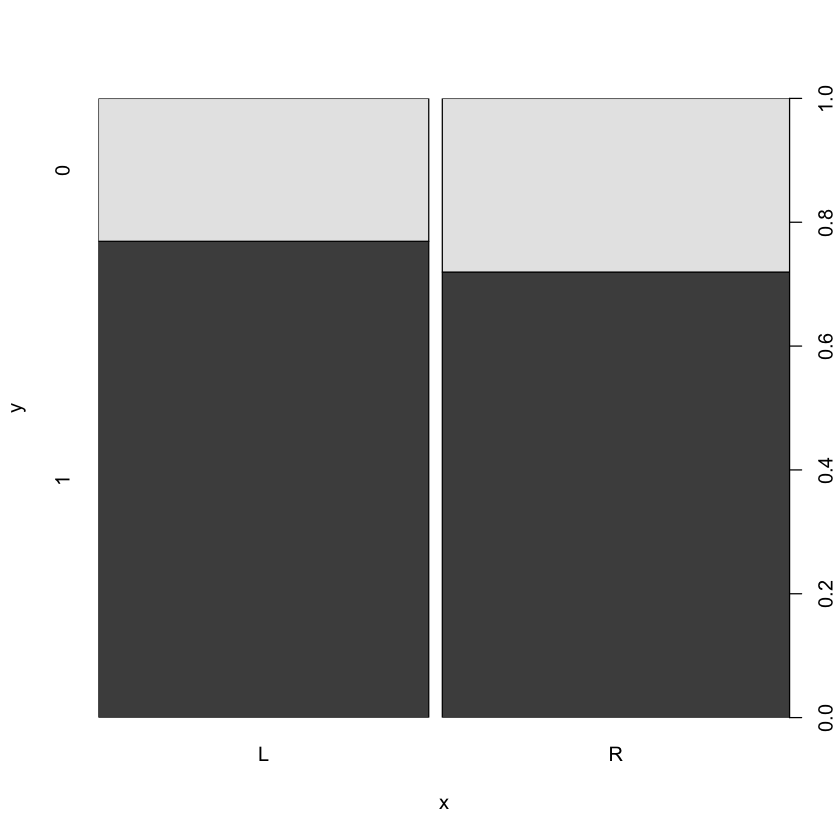

In [17]:
plot(ELP$Reward_Side, ELP$Final_Binary)

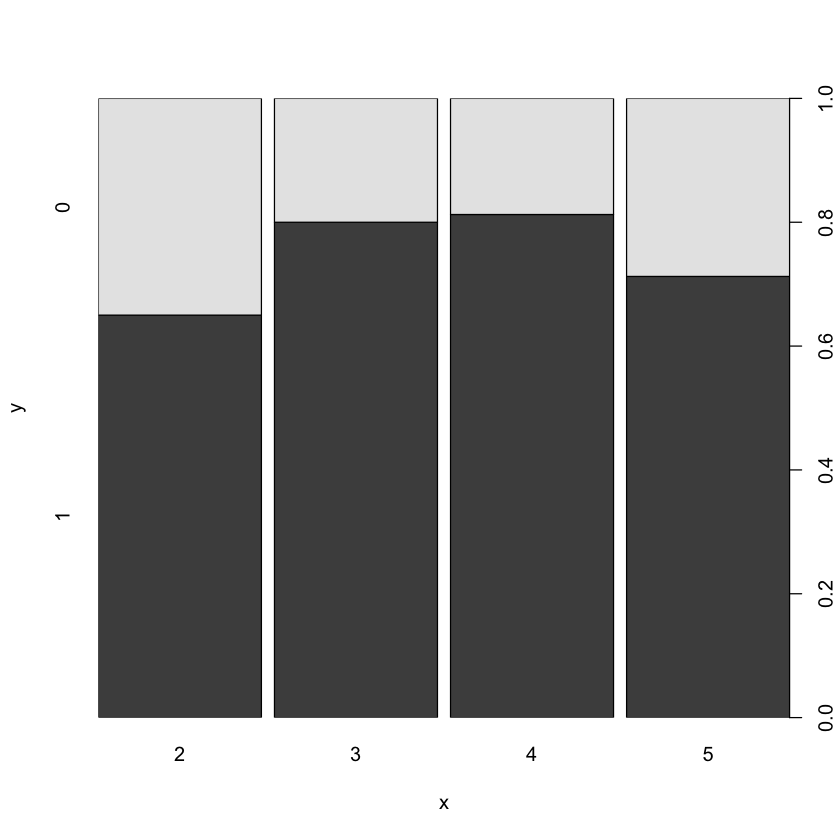

In [18]:
plot(ELP$Visit, ELP$Final_Binary)

## Initial Conclusions
- Consecutive visits seems to increase the number of ants choosing the reward side.
- There seems to be a very slight side bias towards the Left.

## Brain lateralisation VS Visual Cues
**This setup had the wall on the Left!**

## Model averaging

In [19]:
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,7,347.9092,0.000000,1.00000000,0.53509357,-166.7751,0.5350936
1,null_mod,4,350.6139,2.704690,0.25863311,0.13839291,-171.2435,0.6734865
4,side_mod,5,351.3186,3.409336,0.18183271,0.09729752,-170.5638,0.7707840
5,tsm_mod,5,351.8240,3.914730,0.14123006,0.07557130,-170.8164,0.8463553
3,solution_mod,5,352.0304,4.121136,0.12738158,0.06816107,-170.9196,0.9145164
6,solution_time_mod,10,352.7018,4.792516,0.09105805,0.04872458,-165.9949,0.9632409


There is no clearly better model!

In [20]:
top_models = list("visit_mod" = visit_mod, 
                   "null_mod" = null_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_mod" = solution_mod,
                   "solution_time_mod" = solution_time_mod)

modavgShrink(top_models, parm = "(Intercept)")
modavg(top_models, parm = "SolutionDopamine", exclude = "SolutionDopamine:TSM_Bin31-60")
modavgShrink(top_models, parm = "Visit3")
modavgShrink(top_models, parm = "Visit4")
modavgShrink(top_models, parm = "Visit5")
modavg(top_models, parm = "TSM_Bin31-60", exclude = "SolutionDopamine:TSM_Bin31-60")
modavgShrink(top_models, parm = "Reward_SideR")
modavgShrink(top_models, parm = "SolutionDopamine:TSM_Bin31-60")

Warning message in modavgShrink.AICglmerMod(top_models, parm = "(Intercept)"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,7,347.9092,0.000000,1.00000000,0.55551373,-166.7751,0.7091232,0.3776362
null_mod,4,350.6139,2.704690,0.25863311,0.14367424,-171.2435,1.2348551,0.3036155
side_mod,5,351.3186,3.409336,0.18183271,0.10101057,-170.5638,1.4605211,0.3667146
tsm_mod,5,351.8240,3.914730,0.14123006,0.07845524,-170.8164,1.3880371,0.3482525
solution_mod,5,352.0304,4.121136,0.12738158,0.07076222,-170.9196,1.3881811,0.3533792
solution_time_mod,10,352.7018,4.792516,0.09105805,0.05058400,-165.9949,1.0720992,0.4933141


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
solution_mod,5,352.0304,0.0000000,1.0000000,0.5831432,-170.9196,-0.3010749,0.3669752
solution_time_mod,10,352.7018,0.6713799,0.7148447,0.4168568,-165.9949,-0.3888641,0.5112429


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit3"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,7,347.9092,0.000000,1.00000000,0.55551373,-166.7751,0.9397389,0.3993197
null_mod,4,350.6139,2.704690,0.25863311,0.14367424,-171.2435,0.0000000,0.0000000
side_mod,5,351.3186,3.409336,0.18183271,0.10101057,-170.5638,0.0000000,0.0000000
tsm_mod,5,351.8240,3.914730,0.14123006,0.07845524,-170.8164,0.0000000,0.0000000
solution_mod,5,352.0304,4.121136,0.12738158,0.07076222,-170.9196,0.0000000,0.0000000
solution_time_mod,10,352.7018,4.792516,0.09105805,0.05058400,-165.9949,0.9388684,0.3997887


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit4"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,7,347.9092,0.000000,1.00000000,0.55551373,-166.7751,1.034866,0.4050669
null_mod,4,350.6139,2.704690,0.25863311,0.14367424,-171.2435,0.000000,0.0000000
side_mod,5,351.3186,3.409336,0.18183271,0.10101057,-170.5638,0.000000,0.0000000
tsm_mod,5,351.8240,3.914730,0.14123006,0.07845524,-170.8164,0.000000,0.0000000
solution_mod,5,352.0304,4.121136,0.12738158,0.07076222,-170.9196,0.000000,0.0000000
solution_time_mod,10,352.7018,4.792516,0.09105805,0.05058400,-165.9949,1.033975,0.4055640


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit5"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,7,347.9092,0.000000,1.00000000,0.55551373,-166.7751,0.3588379,0.3732810
null_mod,4,350.6139,2.704690,0.25863311,0.14367424,-171.2435,0.0000000,0.0000000
side_mod,5,351.3186,3.409336,0.18183271,0.10101057,-170.5638,0.0000000,0.0000000
tsm_mod,5,351.8240,3.914730,0.14123006,0.07845524,-170.8164,0.0000000,0.0000000
solution_mod,5,352.0304,4.121136,0.12738158,0.07076222,-170.9196,0.0000000,0.0000000
solution_time_mod,10,352.7018,4.792516,0.09105805,0.05058400,-165.9949,0.3583650,0.3736063


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tsm_mod,5,351.8240,0.000000,1.0000000,0.6079952,-170.8164,-0.2972137,0.3172310
solution_time_mod,10,352.7018,0.877786,0.6447498,0.3920048,-165.9949,-0.3901699,0.4848772


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Reward_SideR"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,7,347.9092,0.000000,1.00000000,0.55551373,-166.7751,0.0000000,0.0000000
null_mod,4,350.6139,2.704690,0.25863311,0.14367424,-171.2435,0.0000000,0.0000000
side_mod,5,351.3186,3.409336,0.18183271,0.10101057,-170.5638,-0.4107166,0.3491925
tsm_mod,5,351.8240,3.914730,0.14123006,0.07845524,-170.8164,0.0000000,0.0000000
solution_mod,5,352.0304,4.121136,0.12738158,0.07076222,-170.9196,0.0000000,0.0000000
solution_time_mod,10,352.7018,4.792516,0.09105805,0.05058400,-165.9949,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "SolutionDopamine:TSM_Bin31-60"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,7,347.9092,0.000000,1.00000000,0.55551373,-166.7751,0.0000000,0.0000000
null_mod,4,350.6139,2.704690,0.25863311,0.14367424,-171.2435,0.0000000,0.0000000
side_mod,5,351.3186,3.409336,0.18183271,0.10101057,-170.5638,0.0000000,0.0000000
tsm_mod,5,351.8240,3.914730,0.14123006,0.07845524,-170.8164,0.0000000,0.0000000
solution_mod,5,352.0304,4.121136,0.12738158,0.07076222,-170.9196,0.0000000,0.0000000
solution_time_mod,10,352.7018,4.792516,0.09105805,0.05058400,-165.9949,0.1413677,0.6591128


## Odds
**If the odds is 1 there is no effect, therefore if the CI's cross 1 that is not a significant parameter**

**Intercept** = 2.7 [1.0, 6.9] -> **Ants do not choose an arm of the Y-maze randomly at Visit 2! - almost significant**

**Solution** = 0.7 [0.3, 1.7] -> There is no effect of Solution!

**Visit 3** = 1.8 [0.6, 5.2] -> There is no effect of Visit 3!

**Visit 4** = 1.9 [0.6, 6.0] -> There is no effect of Visit 4!

**Visit 5** = 1.2 [0.6, 2.4] -> There is no effect of Visit 5!

**Side** = 1.0 [0.7, 1.3] -> There is no effect of Side!

**TSM** = 0.7 [0.3, 1.6] -> There is no effect of Time Since Marking!

**SolutionxTSM** = 1.0 [0.7, 1.4] -> There is no effect of Time Since Marking!

## Conclusions
- Ants do not choose a random side of the Y-maze from Visit 2 showing a slight increase in the odds of choosing the reward side as the number of consecutive visits increases suggesting the ants are able to associate the reward with a side.
- There is no effect of Time Since Marking on final choice.
- There is no efect of dopamine on final choice.
- There is no statistically significant side bias although there is a trend towards Left.
- There is no interaction effect of Solution with Time Since Marking.